(35169, 3)
(35169,)
3
1.0
1.1242852001439598
0.38049346183068744
Epoch 1/20
4/4 [==============================] - 3s 290ms/step - loss: 0.0725 - val_loss: 0.1357 - lr: 0.0100
Epoch 2/20
4/4 [==============================] - 0s 103ms/step - loss: 0.0249 - val_loss: 0.0313 - lr: 0.0100
Epoch 3/20
4/4 [==============================] - 0s 104ms/step - loss: 0.0092 - val_loss: 0.0398 - lr: 0.0100
Epoch 4/20
4/4 [==============================] - 0s 103ms/step - loss: 0.0054 - val_loss: 0.0645 - lr: 0.0100
Epoch 5/20
4/4 [==============================] - 0s 121ms/step - loss: 0.0078 - val_loss: 0.0570 - lr: 0.0100
Epoch 6/20
4/4 [==============================] - 0s 110ms/step - loss: 0.0059 - val_loss: 0.0409 - lr: 0.0100
Epoch 7/20
4/4 [==============================] - 0s 102ms/step - loss: 0.0053 - val_loss: 0.0369 - lr: 0.0100
Epoch 8/20
4/4 [==============================] - 0s 101ms/step - loss: 0.0049 - val_loss: 0.0406 - lr: 0.0050
Epoch 9/20
4/4 [==============================]

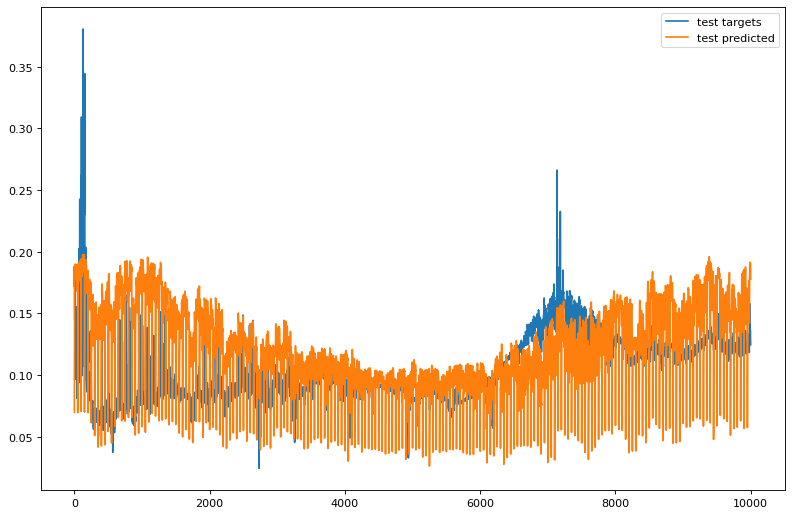

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, TimeDistributed
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, History
import sys
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
import datetime
import os

dataset_df = pd.read_csv("entso_NVE_interpolated.csv", index_col=[0])

#dataset_df["year"] = dataset_df["dato_id"].year

"""
dataset_df_17_18 = dataset_df[dataset_df["year"] > 2016]
dataset_df_17_18 = dataset_df_17_18[dataset_df_17_18["year"] < 2019]
dataset_df_17_18 = dataset_df_17_18.interpolate(method="linear", 
                                        limit_direction="backward", 
                                        limit=3)
print("morrdi")
print(dataset_df_17_18.isna().sum())

dataset_has_nan = dataset_df.isna().sum().sum()
print(dataset_df.isna().sum().sum())
#print(dataset_df.isna().sum())
"""
dataset_df_preprocessed = dataset_df.interpolate(method="linear", 
                                        limit_direction="backward", 
                                        limit=24)


# dataset_df_preprocessed = dataset_df_preprocessed[dataset_df_preprocessed["year"] < 2021]


#print(dataset_df_preprocessed.isna().sum())

#indices = pd.isnull(dataset_df["NO1_Actual Load"]).any().nonzero()[0]
#indices = dataset_df.loc[pd.isna(dataset_df["NO1_Actual Load"]), :].index


test, train = train_test_split(dataset_df_preprocessed, test_size=0.8, shuffle=False)
#train, test = train_test_split(dataset_df_preprocessed, test_size=0.2, shuffle=False)
train, val = train_test_split(train, test_size=0.15, shuffle=False)

# Data columns
target_colums = [f"NO{i}_day_ahead_prices" for i in range(1,6)][4]
load_columns = [f"NO{i}_Actual Load" for i in range(1,6)][4]
nve_columns = [f"NO{i}_Fyllingsgrad_NVE" for i in range(1,6)][4]
generated_columns = [f"NO{i}_generation_actual" for i in range(1,6)][4]
load_forecast_columns = [f"NO{i}_Forecasted Load" for i in range(1,6)][4]
generated_forecast_columns = [f"NO{i}_generation_forecast" for i in range(1,6)][4]

feature_columns =  [generated_forecast_columns] + [load_forecast_columns] + [nve_columns]
#feature_columns =  generated_columns + load_columns 


# Create correlation matrix
#corr_df = dataset_df[target_colums].corr(method="spearman")

"""
# Plot
fig, axs = plt.subplots(1, 1,figsize=(3.5, 2.5))
sns.heatmap(abs(corr_df), annot=True, cmap = cm.lajolla_r, fmt='.2f', ax=axs)
axs.set_title(f'Correlation analysis on targets')

# Save the figure.
fig.savefig(f"{REPORT_FIGURES}target_corr_analysis.pdf", bbox_inches='tight')
"""

# Training, validation and test data
target_colums = target_colums


t_train = train[target_colums].to_numpy()
X_train = train[feature_columns].to_numpy()

t_val = val[target_colums].to_numpy()
X_val = val[feature_columns].to_numpy()

t_test = test[target_colums].to_numpy()
X_test = test[feature_columns].to_numpy()


# Scaling 
""""""
print(f"{X_train.shape}")
print(f"{t_train.shape}")
X_scaler = MinMaxScaler()
X_scaler.fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
X_val = X_scaler.transform(X_val)

t_scaler = MinMaxScaler()
t_scaler.fit(t_train.reshape(-1,1))
t_train = t_scaler.transform(t_train.reshape(-1,1)).flatten()
t_test = t_scaler.transform(t_test.reshape(-1,1)).flatten()
t_val = t_scaler.transform(t_val.reshape(-1,1)).flatten()


# Model architecture
class LSTM_model(Sequential):
    def __init__(self, eta, rnn_units, model_shape, nbf_outputs=1):
        super(self.__class__, self).__init__()
       
        # LSTM layer
        self.add(LSTM(rnn_units, input_shape = model_shape, return_sequences = True))
        #self.add(LSTM(rnn_units, input_shape = model_shape))
        
        # # Dense layer
        # self.add(Dense(rnn_units, activation='relu'))
        
        # Normalization
        #self.add(BatchNormalization())

        # Dropouts
        self.add(Dropout(0.15))

        # Output layer
        self.add(Dense(nbf_outputs))

        # Model compile settings
        opt = tf.keras.optimizers.Adam(learning_rate=eta)
        
        ## Compile model
        self.compile(loss='mse', optimizer=opt)

# Model shape 
time_steps = 50
nbf_features = X_train.shape[1]
print(nbf_features)
model_shape = (time_steps, nbf_features) 

# (batch_size, time_steps, nbf_features)
# shape going into the model (488,72,10)

# shape going into the model (nbf_batches, batch_size, time_steps, features)
#(4, 122, 72, 10)

# Data preprocessing
# Training data
X_train_m = X_train[35169-35000: ].copy() #
t_train_m = t_train[35169-35000:].copy() # 

batch_size_train = X_train_m.shape[0] // time_steps
X_train_m = X_train_m.reshape((batch_size_train, time_steps, nbf_features))

t_train_m = t_train_m.reshape((batch_size_train, time_steps, 1))


# Validation data
X_val_m = X_val[6207-5000: ].copy() #
t_val_m = t_val[6207-5000:].copy() # 

batch_size_val = X_val_m.shape[0] // time_steps
X_val_m = X_val_m.reshape((batch_size_val, time_steps, nbf_features))
t_val_m = t_val_m.reshape((batch_size_val, time_steps, 1))

# Test data
X_test_m = X_test[10344-10000: ].copy() #
t_test_m = t_test[10344-10000: ].copy() # 

batch_size_test = X_test_m.shape[0] // time_steps
X_test_m = X_test_m.reshape((batch_size_test, time_steps, nbf_features))
t_test_m = t_test_m.reshape((batch_size_test, time_steps, 1))


# Hyperparameters
eta = 0.01
rnn_units = 64
batch_size = 200
EPOCHS=20
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0001)

# Tensorboard
log_dir = f"data/report_data/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# log_dir = f"{REPORT_DATA}logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

print(t_train_m.max())
print(t_val_m.max())
print(t_test_m.max())



model = LSTM_model(eta, rnn_units,model_shape, nbf_outputs=1)
model.fit(X_train_m, t_train_m, 
          shuffle=False, 
          batch_size=batch_size, 
          epochs=EPOCHS, 
          validation_data=(X_val_m, t_val_m),
          callbacks=[reduce_lr, tensorboard_callback],
          verbose=1)
print(model.summary())



# predict
t_hat_train = model.predict(X_train_m)
t_hat_test_m = model.predict(X_test_m)

test_MSE = MSE(t_test_m.flatten(), t_hat_test_m.flatten())

print(test_MSE)






figure(figsize=(12, 8), dpi=80)
x_plot = np.arange(t_test_m.flatten().shape[0])
plt.plot(x_plot, t_test_m.flatten(), label="test targets")
plt.plot(x_plot, t_hat_test_m.flatten(), label="test predicted")
# plt.xticks(test.loc[10344-10000: , 'dato_id'])
plt.legend()
plt.show()
